In [1]:
seed = 1234
results_action = 'load'# simulate, simulate_and_save or load

## Imports

In [2]:
import numpy as np
from rl.environments import RW, episode_length_distribution
from rl.plotting import plot_heatmap, plot_parallel_comparison, plot_best_param_comparison, plot_best_and_div_alpha__comparison, plot_best_comparison
from rl.algorithms import nstepTD_rec, λreturn_rec, TTDλ, TDλ, ETλ, comparison
from rl.value_functions import StateValueFunction
from utils.results import save_results, load_results, flt
legend_best = {'borderaxespad': 0., 'frameon': False}
legend_top = {'bbox_to_anchor': (0., 1.02, 2., .102), 'loc': 'lower left', 'ncol': 5, 'mode':'expand', 'borderaxespad': 0.}
legend_top_2col = {'bbox_to_anchor': (0., 1.02, 1., .102), 'loc': 'lower left', 'ncol': 2, 'mode':'expand', 'borderaxespad': 0.}
legend_top_3col = {'bbox_to_anchor': (0., 1.02, 1., .102), 'loc': 'lower left', 'ncol': 3, 'mode':'expand', 'borderaxespad': 0.}

## Environment

In [3]:
env_name = 'RW'
results_path = f'results/{env_name}/rmse'
environment = RW
env_n = 19
aggr_groups = None
gamma = 1.0

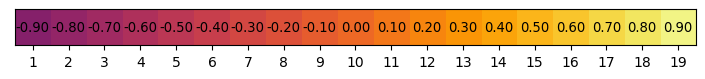

In [4]:
plot_heatmap(environment(env_n).calculate_value_function(gamma),None,labels_color='0.0',vmin=-2.0,vmax=1.0, xticks=[f"{x}" for x in np.arange(1,env_n+1)], yticks=[], save_file=f'results/{env_name}/plots/{env_name}_v')

In [5]:
environment(env_n, terminal_rewards=(1.0,1.0), reward=1.0).calculate_value_function(gamma)[env_n//2]

99.99999748282903

In [6]:
%%time
l = episode_length_distribution(1000, environment, env_n, seed)

CPU times: user 1.36 s, sys: 3.88 ms, total: 1.36 s
Wall time: 1.59 s


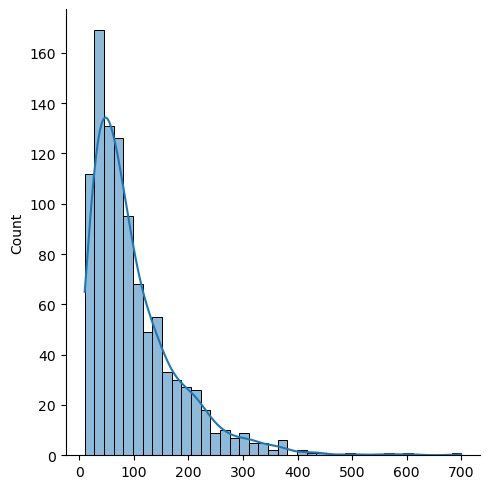

In [7]:
import seaborn as sns
sns.displot(l, kde=True)

## Results

### Evaluation

In [8]:
algorithms = ['n-step TD', 'λ-return alg.', 'TTD(λ)', 'accumulate TD(λ)', 'replace TD(λ)', 'true online TD(λ)', 'accumulate ET(λ)', 'replace ET(λ)', 'true online ET(λ)']
alg_colors = {algorithm_name: col for algorithm_name,col in zip(algorithms,['tab:green','black', 'tab:pink','goldenrod','orangered','tab:red','tab:cyan','tab:blue','tab:purple'])}
results = {algorithm_name: {'online': None, 'single-update': None} for algorithm_name in algorithms}

In [9]:
value_function = StateValueFunction
to_return = 'rmse_ep'
runs = 100
episodes = 50
operation = 'mean'
last = None
first = 10
skip_first = True

#### Variables

In [10]:
initial_value = 0.0
alpha_strategy = 'fixed'
# alpha_values = np.linspace(0.0, 1.0, 26)
alpha_values = np.append(np.linspace(0, 0.2, 20, endpoint=False),np.linspace(0.2, 1.0, 41))
beta = None
n_values = np.array([1,2,4,8,16,32,64,128,256,512])
lambda_values = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.82,0.84,0.86,0.88,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0])
lines_filter = {
    'n': [True]*len(n_values),
    'λ': [True,False,True,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,True]
}
processes = None
show_progress_bar = True
bar_desc = None
leave_bar = False
ylim = (0.15,0.85)

#### n-step TD

In [11]:
algorithm_name = 'n-step TD'
algorithm_function = nstepTD_rec
variable = 'n'

In [12]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(n_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, n_values, env_n, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [13]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(n_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, n_values, env_n, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

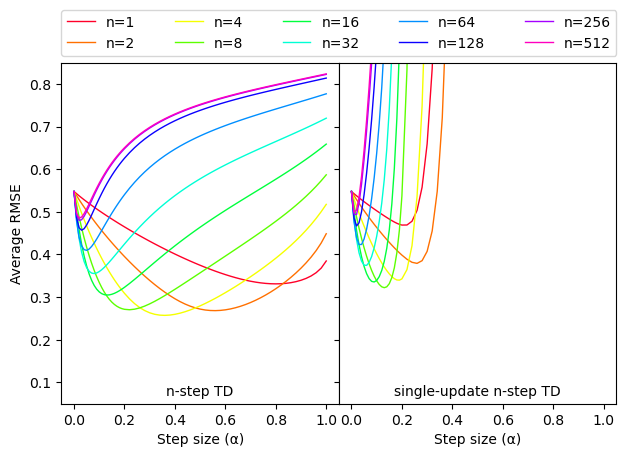

In [14]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, n_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=(0.05,0.85), legend_kwargs=legend_top, ylabel="Average RMSE", save_file=f'results/{env_name}/plots/{env_name}_nstep')

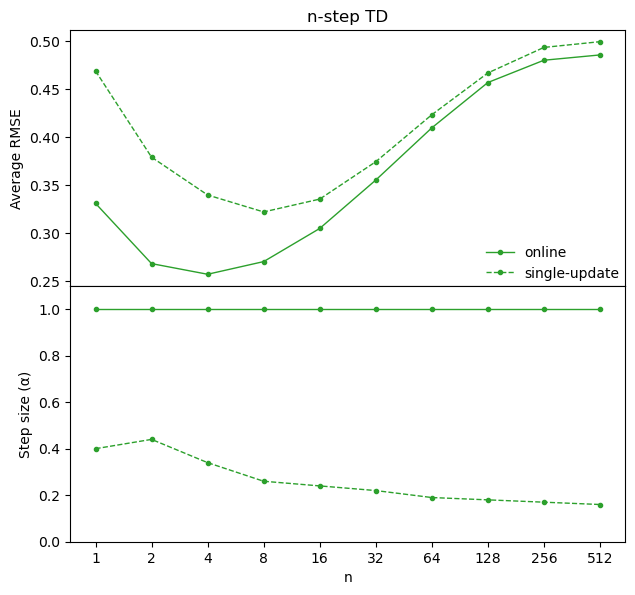

In [15]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], n_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', legend_kwargs=legend_best, marker='.', save_file=f'results/{env_name}/plots/{env_name}_nstep_c')

#### λ-return alg.

In [16]:
algorithm_name = 'λ-return alg.'
algorithm_function = λreturn_rec
variable = 'λ'

In [17]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [18]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

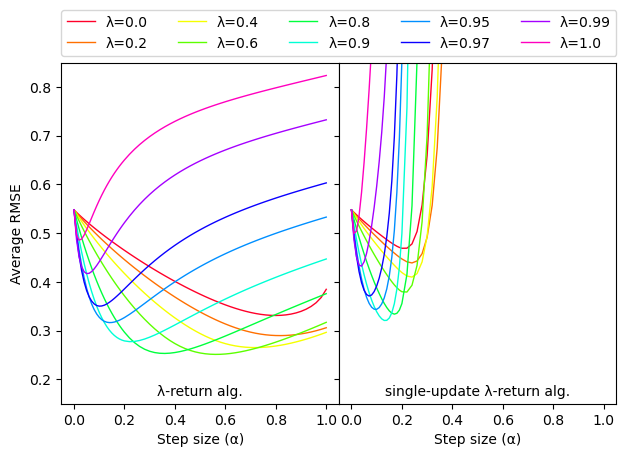

In [19]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

/notebooks/rl/plotting.py:122: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  ax[0].plot(x_values, np.min(rmse, axis=1), marker, label=label, color=colors[i][0], linestyle =colors[i][1], linewidth=1.0) if colors else ax[0].plot(x_values, np.min(rmse, axis=1), marker, linestyle ='solid', label=label, linewidth=1.0)
/notebooks/rl/plotting.py:133: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  ax[1].plot(x_values, alpha_values[indexes], marker, label=label, color=colors[i][0], linestyle =colors[i][1], linewidth=1.0) if colors else ax[1].plot(x_values, alpha_values[indexes], marker, linestyle ='solid', label=label, linewidth=1.0)


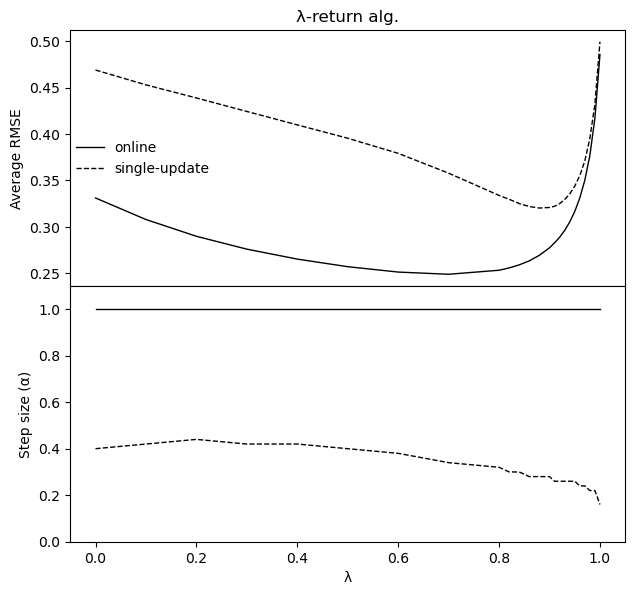

In [20]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### TTD(λ)

In [21]:
algorithm_name = 'TTD(λ)'
algorithm_function = TTDλ
variable = 'λ'
eta = 0.01

In [22]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}_{eta}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, eta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [23]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}_{eta}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, eta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

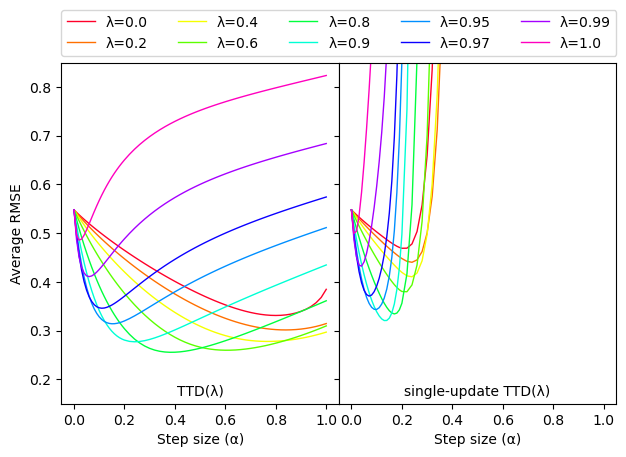

In [24]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

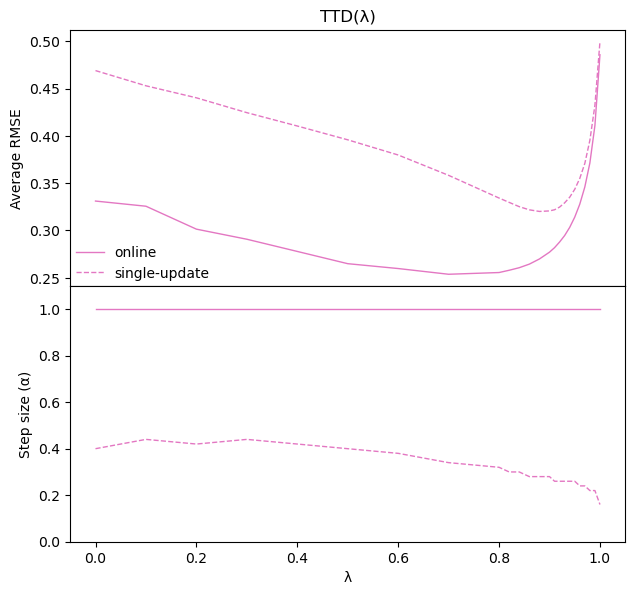

In [25]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### accumulate TD(λ)

In [26]:
algorithm_name = 'accumulate TD(λ)'
algorithm_function = TDλ
algorithm_type = 'accumulate'
variable = 'λ'

In [27]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [28]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

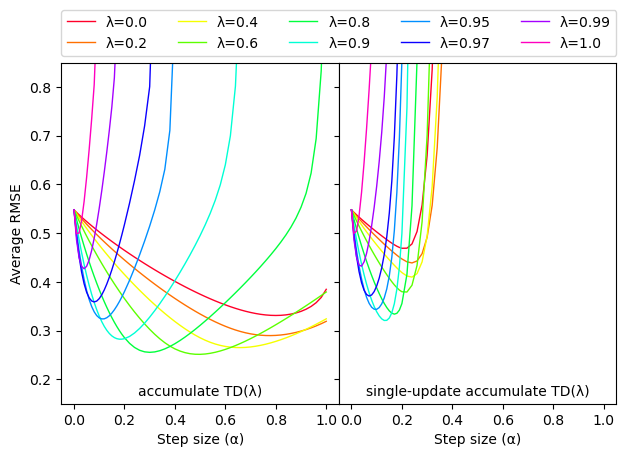

In [29]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

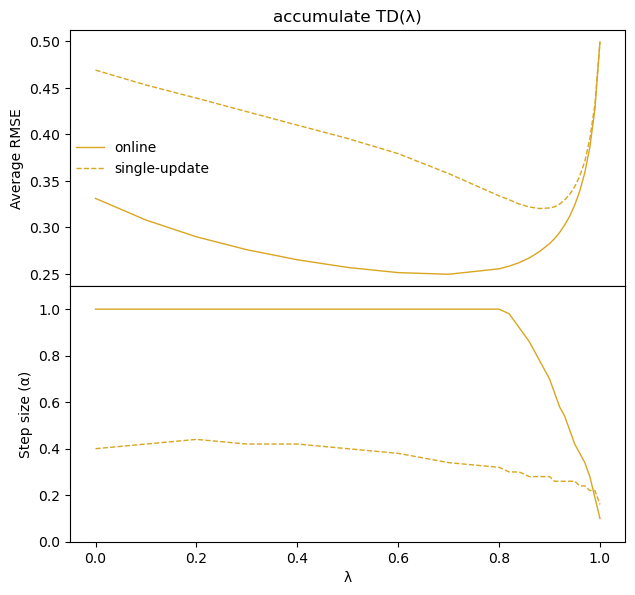

In [30]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### replace TD(λ)

In [31]:
algorithm_name = 'replace TD(λ)'
algorithm_function = TDλ
algorithm_type = 'replace'
variable = 'λ'

In [32]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [33]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

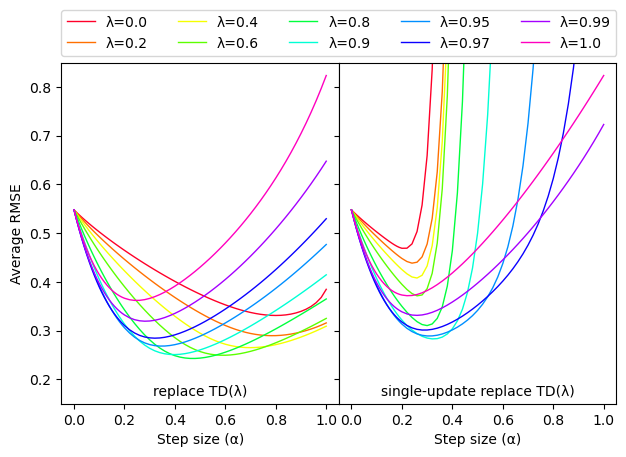

In [34]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

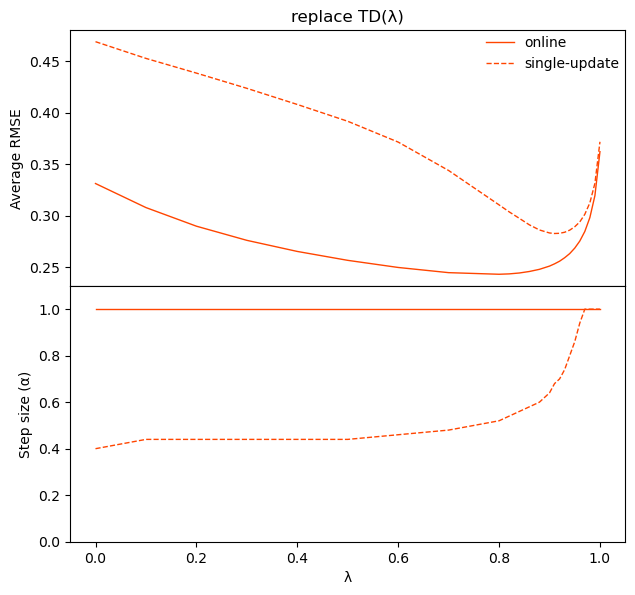

In [35]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### true online TD(λ)

In [36]:
algorithm_name = 'true online TD(λ)'
algorithm_function = TDλ
algorithm_type = 'true_online'
variable = 'λ'

In [37]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [38]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

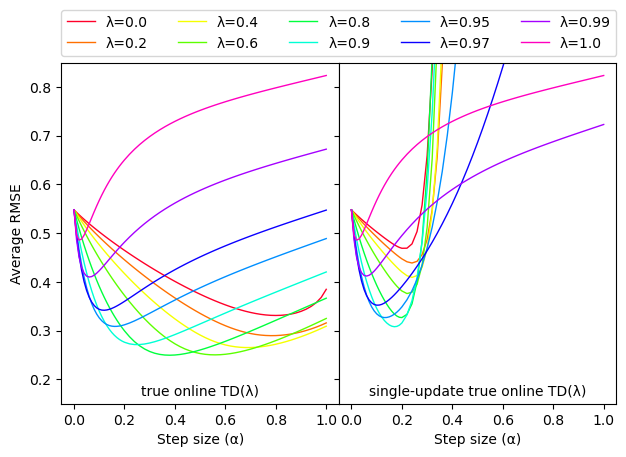

In [39]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

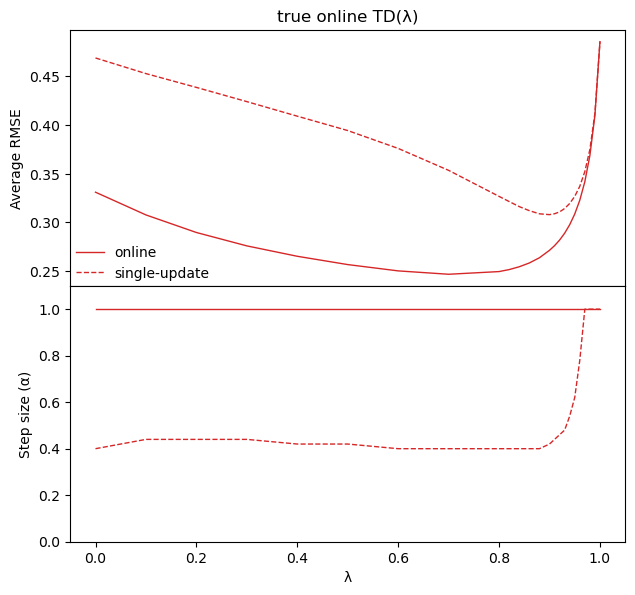

In [40]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### Comparison

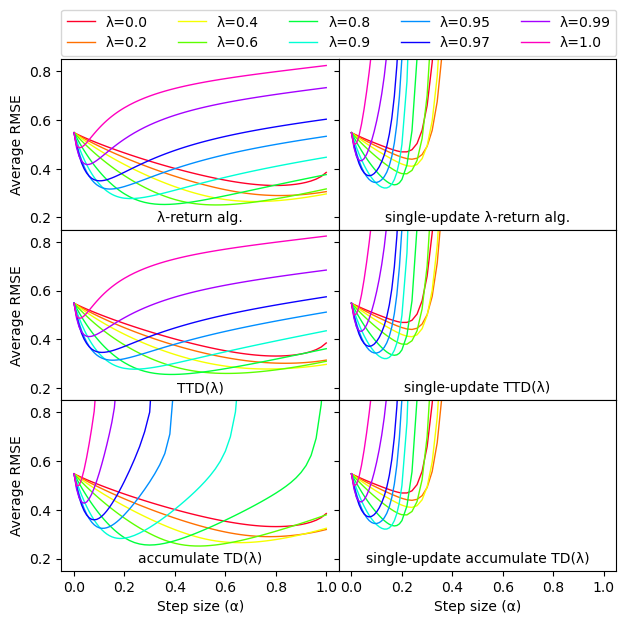

In [41]:
data_to_compare = [[('λ-return alg.', 'online'), ('λ-return alg.', 'single-update')], [('TTD(λ)', 'online'), ('TTD(λ)', 'single-update')], [('accumulate TD(λ)','online'), ('accumulate TD(λ)','single-update')]]
plot_parallel_comparison([[flt(results[a][t], operation, last, first, skip_first, lines_filter[variable]) for a,t in d] for d in data_to_compare], alpha_values, lambda_values[lines_filter[variable]], variable, [[f"{t+' ' if t=='single-update' else ''}{a}" for a,t in d] for d in data_to_compare], ylim=ylim, legend_kwargs=legend_top, save_file=f"results/{env_name}/plots/{env_name}_lambda")

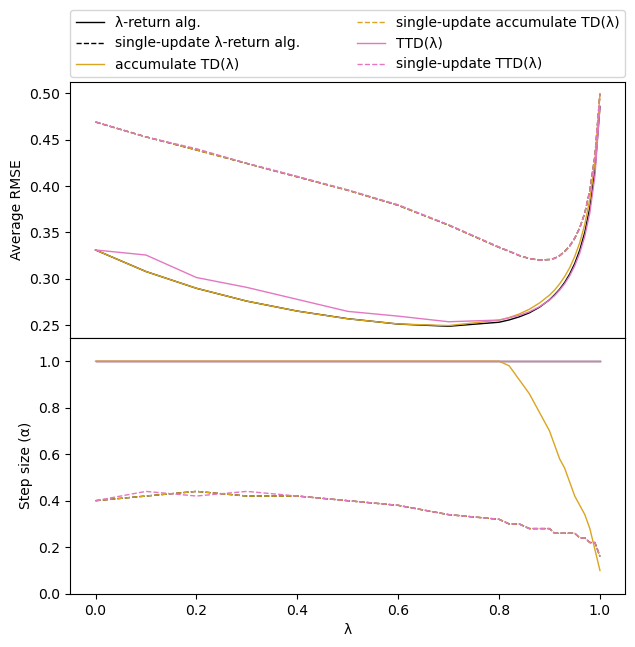

In [42]:
data_to_compare = [('λ-return alg.', 'online'), ('λ-return alg.', 'single-update'), ('accumulate TD(λ)','online'), ('accumulate TD(λ)','single-update'), ('TTD(λ)', 'online'), ('TTD(λ)', 'single-update')]
plot_best_and_div_alpha__comparison([flt(results[a][t], operation, last, first, skip_first) for a,t in data_to_compare], lambda_values, alpha_values, [f"{t+' ' if t=='single-update' else ''}{a}" for a,t in data_to_compare], None, variable, log_scale = variable=='n', set_ticks = False, colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], legend_kwargs=legend_top_2col, save_file=f"results/{env_name}/plots/{env_name}_lambda_c")

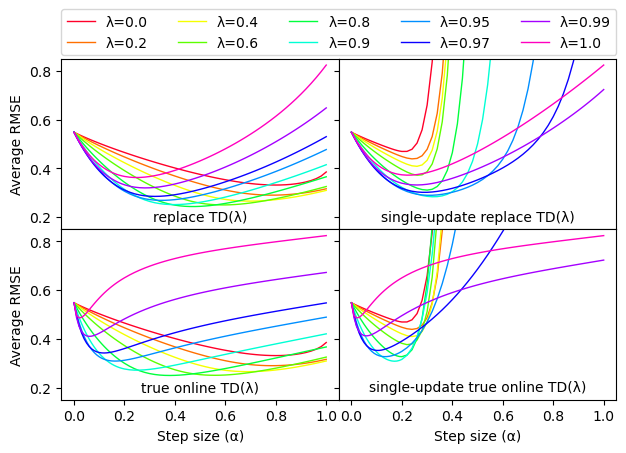

In [43]:
data_to_compare = [[('replace TD(λ)','online'), ('replace TD(λ)','single-update')], [('true online TD(λ)','online'), ('true online TD(λ)','single-update')]]
plot_parallel_comparison([[flt(results[a][t], operation, last, first, skip_first, lines_filter[variable]) for a,t in d] for d in data_to_compare], alpha_values, lambda_values[lines_filter[variable]], variable, [[f"{t+' ' if t=='single-update' else ''}{a}" for a,t in d] for d in data_to_compare], ylim=ylim, legend_kwargs=legend_top, save_file=f"results/{env_name}/plots/{env_name}_tdl")

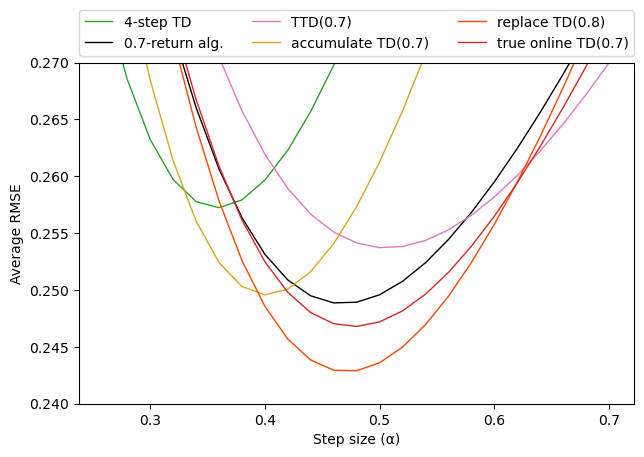

In [44]:
data_to_compare = [('n-step TD', 'online'), ('λ-return alg.', 'online'), ('TTD(λ)','online'), ('accumulate TD(λ)','online'), ('replace TD(λ)','online'), ('true online TD(λ)','online')]
plot_best_param_comparison([(lambda_values if 'λ' in a else n_values, flt(results[a][t], operation, last, first, skip_first)) for a,t in data_to_compare], alpha_values, [f"{t+' ' if t=='single-update' else ''}{a}".replace('λ', '{}').replace('n-step', '{}-step') for a,t in data_to_compare], None, alphalim=(0.25,0.7), colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], ylim=(0.24,0.27), legend_kwargs=legend_top_3col, save_file=f"results/{env_name}/plots/{env_name}_best_c")

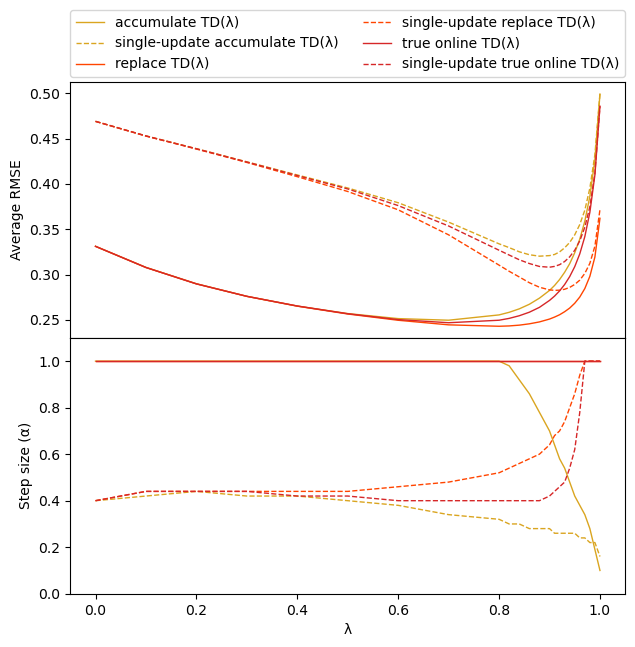

In [45]:
data_to_compare = [('accumulate TD(λ)','online'), ('accumulate TD(λ)','single-update'), ('replace TD(λ)','online'), ('replace TD(λ)','single-update'), ('true online TD(λ)','online'), ('true online TD(λ)','single-update')]
plot_best_and_div_alpha__comparison([flt(results[a][t], operation, last, first, skip_first) for a,t in data_to_compare], lambda_values, alpha_values, [f"{t+' ' if t=='single-update' else ''}{a}" for a,t in data_to_compare], None, variable, log_scale = variable=='n', set_ticks = False, colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], legend_kwargs=legend_top_2col, save_file=f"results/{env_name}/plots/{env_name}_tdl_c")

### Experiments

#### accumulate ET(λ)

In [46]:
algorithm_name = 'accumulate ET(λ)'
algorithm_function = ETλ
algorithm_type = 'accumulate'
variable = 'λ'

In [47]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}_{beta}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, beta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [48]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}_{beta}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, beta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

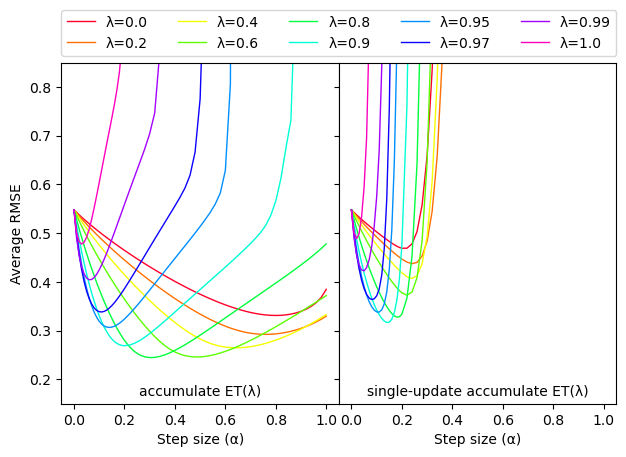

In [49]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

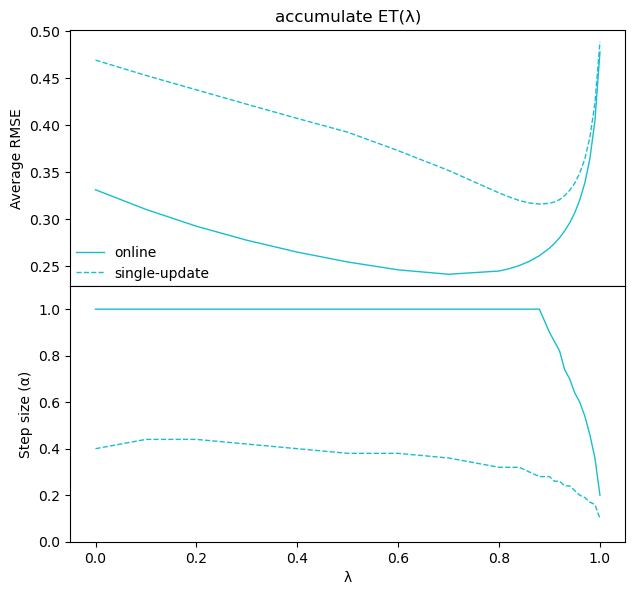

In [50]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### replace ET(λ)

In [51]:
algorithm_name = 'replace ET(λ)'
algorithm_function = ETλ
algorithm_type = 'replace'
variable = 'λ'

In [52]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}_{beta}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, beta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [53]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}_{beta}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, beta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

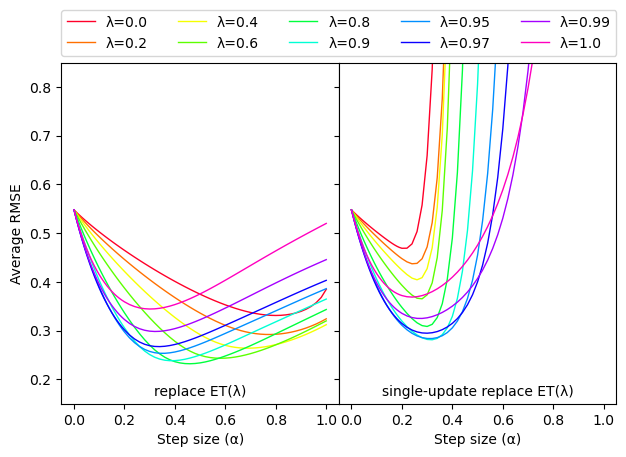

In [54]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

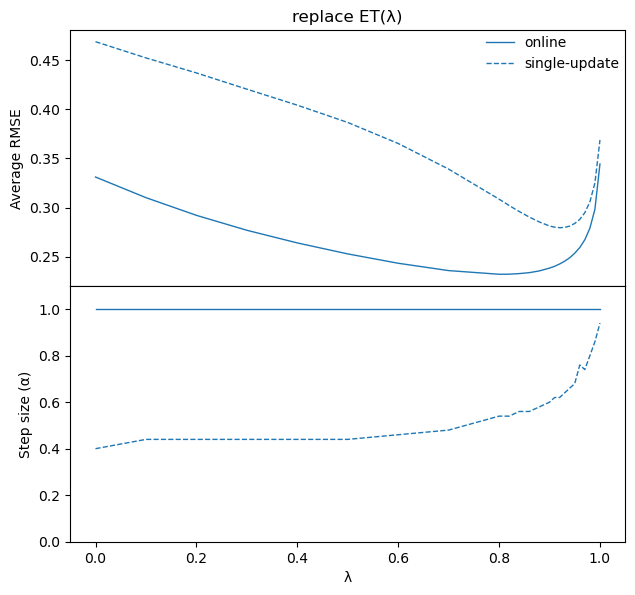

In [55]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### true online ET(λ)

In [56]:
algorithm_name = 'true online ET(λ)'
algorithm_function = ETλ
algorithm_type = 'true_online'
variable = 'λ'

In [57]:
single_update = False
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_online_{len(lambda_values)}_{beta}'
if 'simulate' in results_action:
    results[algorithm_name]['online'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, beta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['online'])
else:
    results[algorithm_name]['online'] = load_results(results_path, file_name)

In [58]:
single_update = True
file_name = f'{episodes}_{runs}_{env_n}_{aggr_groups if aggr_groups else 0}_{algorithm_name}_single-update_{len(lambda_values)}_{beta}'
if 'simulate' in results_action:
    results[algorithm_name]['single-update'] = comparison(environment, algorithm_function, runs, episodes, alpha_values, lambda_values, env_n, algorithm_type, beta, gamma, value_function, initial_value, aggr_groups, alpha_strategy, single_update, to_return, seed=seed, processes=processes, show_progress_bar=show_progress_bar, bar_desc=bar_desc, leave_bar=leave_bar)
    if 'save' in results_action:
        save_results(results_path, file_name, results[algorithm_name]['single-update'])
else:
    results[algorithm_name]['single-update'] = load_results(results_path, file_name)

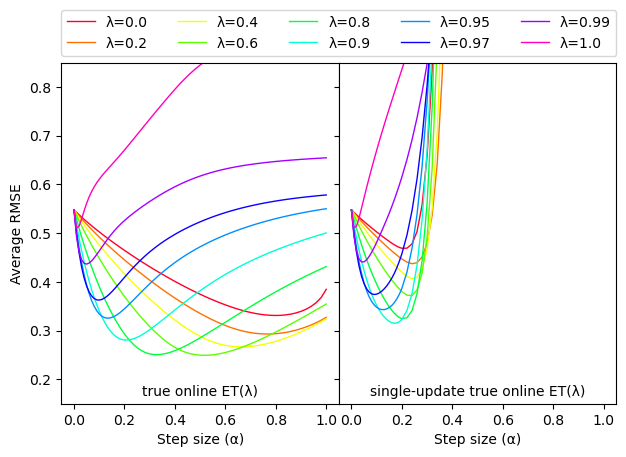

In [59]:
plot_parallel_comparison([(flt(results[algorithm_name]['online'], operation, last, first, skip_first, lines_filter[variable]), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first, lines_filter[variable]))], alpha_values, lambda_values[lines_filter[variable]], variable, [(algorithm_name, f'single-update {algorithm_name}')], ylim=ylim, legend_kwargs=legend_top)

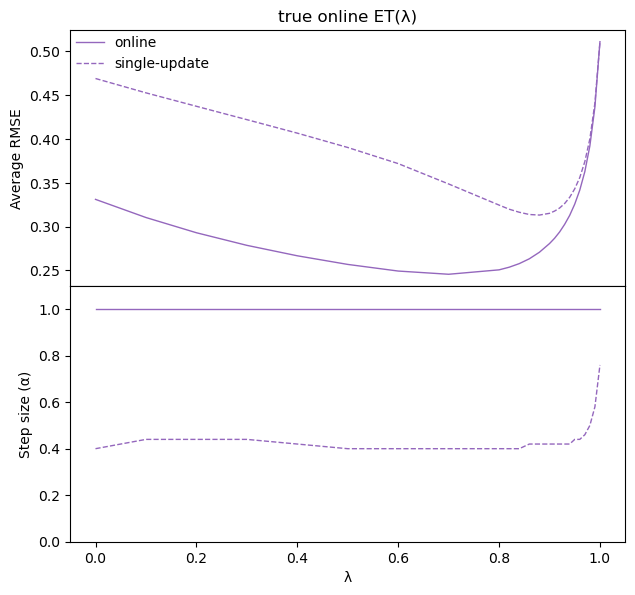

In [60]:
plot_best_and_div_alpha__comparison([flt(results[algorithm_name]['online'], operation, last, first, skip_first), flt(results[algorithm_name]['single-update'], operation, last, first, skip_first)], lambda_values, alpha_values, ['online','single-update'], algorithm_name, variable, colors = [(alg_colors[algorithm_name],'solid'),(alg_colors[algorithm_name],'dashed')], log_scale = variable=='n', set_ticks=False, legend_kwargs=legend_best)

#### Comparison

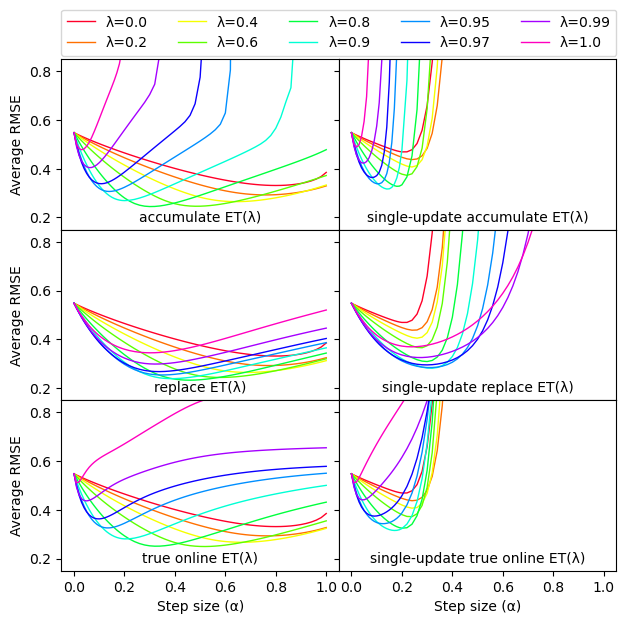

In [61]:
data_to_compare = [[('accumulate ET(λ)','online'), ('accumulate ET(λ)','single-update')], [('replace ET(λ)','online'), ('replace ET(λ)','single-update')], [('true online ET(λ)','online'), ('true online ET(λ)','single-update')]]
plot_parallel_comparison([[flt(results[a][t], operation, last, first, skip_first, lines_filter[variable]) for a,t in d] for d in data_to_compare], alpha_values, lambda_values[lines_filter[variable]], variable, [[f"{t+' ' if t=='single-update' else ''}{a}" for a,t in d] for d in data_to_compare], ylim=ylim, legend_kwargs=legend_top)#, save_file=f"results/{env_name}/plots/{env_name}_et")

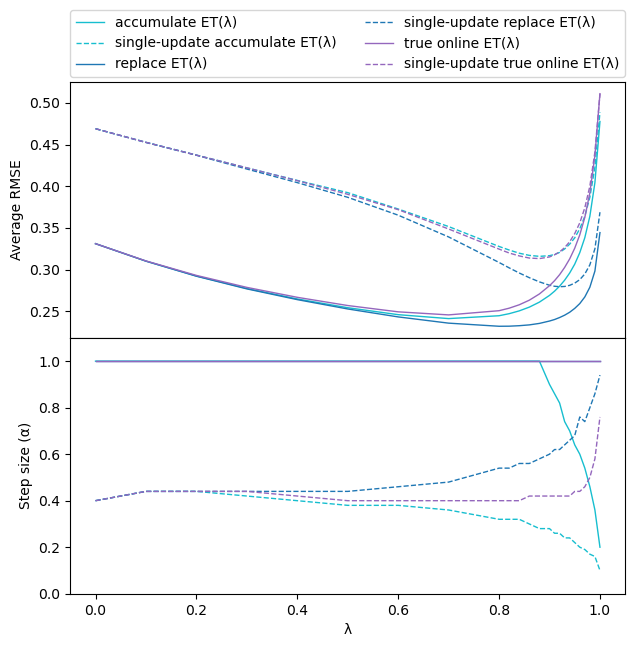

In [62]:
data_to_compare = [('accumulate ET(λ)','online'), ('accumulate ET(λ)','single-update'), ('replace ET(λ)','online'), ('replace ET(λ)','single-update'), ('true online ET(λ)','online'), ('true online ET(λ)','single-update')]
plot_best_and_div_alpha__comparison([flt(results[a][t], operation, last, first, skip_first) for a,t in data_to_compare], lambda_values, alpha_values, [f"{t+' ' if t=='single-update' else ''}{a}" for a,t in data_to_compare], None, variable, log_scale = variable=='n', set_ticks = False, colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], legend_kwargs=legend_top_2col)

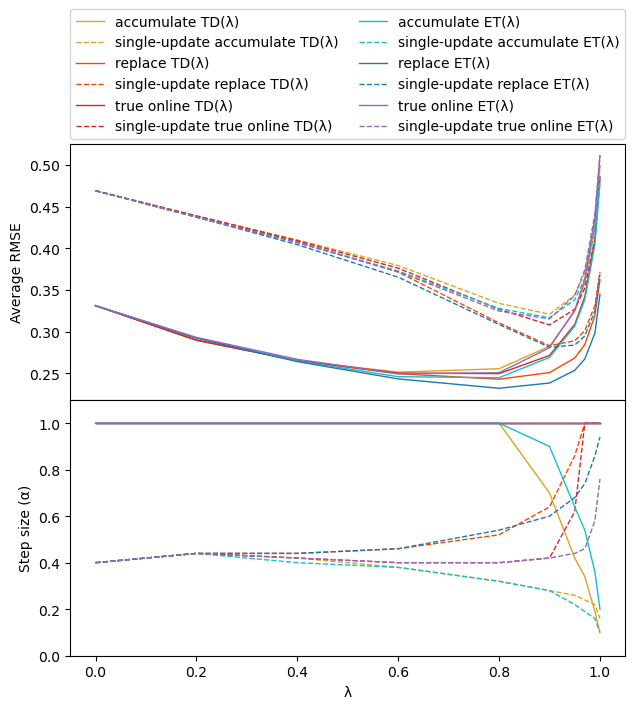

In [63]:
data_to_compare = [('accumulate TD(λ)','online'), ('accumulate TD(λ)','single-update'), ('replace TD(λ)','online'), ('replace TD(λ)','single-update'), ('true online TD(λ)','online'), ('true online TD(λ)','single-update'), ('accumulate ET(λ)','online'), ('accumulate ET(λ)','single-update'), ('replace ET(λ)','online'), ('replace ET(λ)','single-update'), ('true online ET(λ)','online'), ('true online ET(λ)','single-update')]
plot_best_and_div_alpha__comparison([flt(results[a][t], operation, last, first, skip_first, lines_filter[variable]) for a,t in data_to_compare], lambda_values[lines_filter[variable]], alpha_values, [f"{t+' ' if t=='single-update' else ''}{a}" for a,t in data_to_compare], None, variable, log_scale = variable=='n', set_ticks = False, colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], legend_kwargs=legend_top_2col)#, save_file=f"results/{env_name}/plots/{env_name}_etvstd")

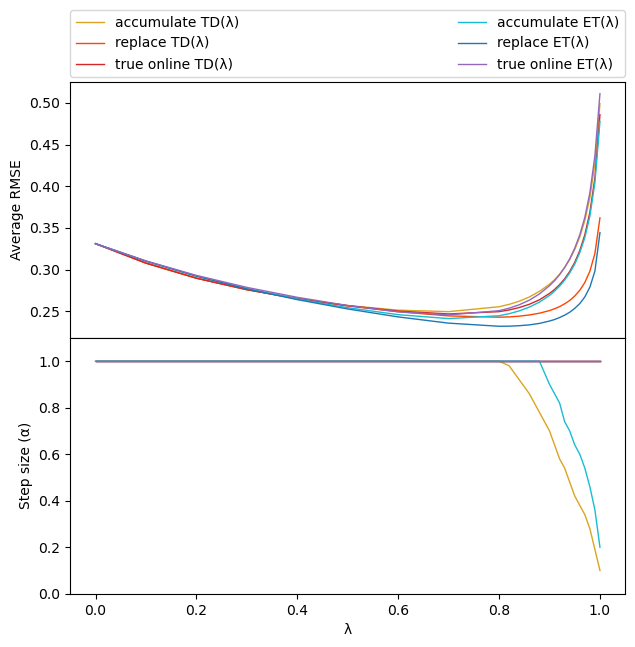

In [64]:
data_to_compare = [('accumulate TD(λ)','online'), ('replace TD(λ)','online'), ('true online TD(λ)','online'), ('accumulate ET(λ)','online'), ('replace ET(λ)','online'), ('true online ET(λ)','online')]
plot_best_and_div_alpha__comparison([flt(results[a][t], operation, last, first, skip_first) for a,t in data_to_compare], lambda_values, alpha_values, [f"{t+' ' if t=='single-update' else ''}{a}" for a,t in data_to_compare], None, variable, log_scale = variable=='n', set_ticks = False, colors = [(alg_colors[a],'dashed' if t=='single-update' else 'solid') for a,t in data_to_compare], legend_kwargs=legend_top_2col)

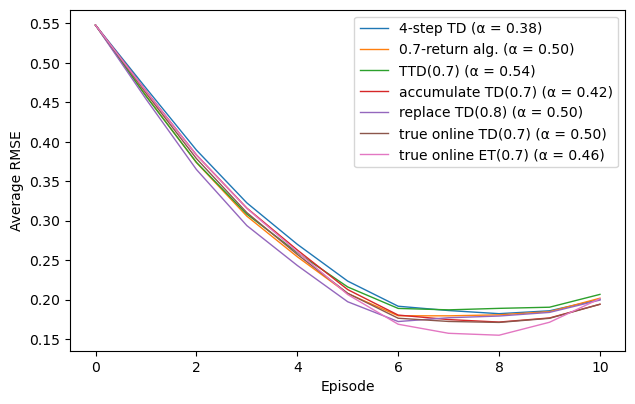

In [66]:
data_to_compare = [('n-step TD', 'online'), ('λ-return alg.', 'online'), ('TTD(λ)','online'), ('accumulate TD(λ)','online'), ('replace TD(λ)','online'), ('true online TD(λ)','online'), ('true online ET(λ)','online')]
plot_best_comparison(results, data_to_compare, alpha_values, lambda_values, n_values, operation, last, first, False)